In [1]:
# Disable warning
import warnings
warnings.filterwarnings('ignore')

# Import GLAD drifter data

In [2]:
# import numpy
import numpy as np

# import datetime
from datetime import datetime

# get parent directory of working directory
import os
parentdirectory = os.path.dirname(os.getcwd())

# Import pandas
import pandas as pd

# get data directory where preprocesed GDP drifter data is stored.
# All the GDP drifters which were continuously active from the 10/08/2012 to the 17/08/2012  are stored in this directory.
data_directory = parentdirectory+"/data/GLAD/Drifter_processed"

drifters = []

for r, d, f in os.walk(data_directory):
    # r=root, d=directories, f = files
    for file in f:
        if file.endswith(".csv"):
            csv_file = pd.read_csv(r+"/"+file).values
            time_string = csv_file[:,0]
            time_datetime = [datetime.strptime(s, '%Y-%m-%d %H:%M:%S') for s in time_string]
            time_seconds = [0]
            for i in range(len(time_datetime)-1):
                time_seconds.append(int((time_datetime[i+1]-time_datetime[0]).total_seconds()))
            longitude = csv_file[:,1]
            latitude = csv_file[:,2]
            drifters.append([time_seconds, longitude, latitude])

# Import LAVD data

In [3]:
# define directory of data
data_directory_LAVD = parentdirectory+"/data/GLAD/AVISO/LAVD"
LAVD_x = []

from natsort import natsorted

for r, d, f in os.walk(data_directory_LAVD):
    f = natsorted(f)
    for file in f:
        if file.endswith(".csv"):
            csv_file = pd.read_csv(r+"/"+file).values
            LAVD_x.append([csv_file[:,1], csv_file[:,2]])
            
LAVD_x = np.array(LAVD_x)

# Import Attracting LCS

The attracting LCS is computed from backwards trajectories over the time-interval $ [222 \ \mathrm{doy}, 229 \ \mathrm{doy}] $ from the geostrophic velocity field (=AVISO). The computation is done using the [TBarrier](https://github.com/EncinasBartos/TBarrier) notebook series.

In [4]:
# import scipy
from scipy.io import loadmat

AttractingLCS = loadmat("AttractingLCS.mat")
AttractingLCS_x = AttractingLCS["attractingLCS_x"]
AttractingLCS_y = AttractingLCS["attractingLCS_y"]

# Compute TRA

In [5]:
# import function to compute TRA
from ipynb.fs.defs.TRA import __TRA__

TRA, long, lat = [], [], []
long_final, lat_final = [], []
long_init, lat_init = [], []

# iterate over all drifters:
for d in drifters:
    
    # time
    time = d[0]
    #longitudinal position of drifter d
    longitude = d[1]
    # latitudinal position of drifter d
    latitude = d[2]
    # TRA associated to drifter d over the time d[0]
    f = 96 # Drifters are sampled at 1/15 min --> 1/96 days
    TRA.append(__TRA__(longitude, latitude, time, f))
    
    # Append longitude/latitude
    long.append(longitude)
    lat.append(latitude)
    
    # store final position
    long_final.append(longitude[-1])
    lat_final.append(latitude[-1])
    
    # store initiail position
    long_init.append(longitude[-1])
    lat_init.append(latitude[-1])

# Interpolate data from scattered grid to regular meshgrid using rbf-interpolation

In [6]:
# import scipy
from scipy import ndimage, misc
from metpy.interpolate import interpolate_to_grid
import sys

# import cv2 for spatial average filtering
import cv2

from tqdm.notebook import tqdm

# linear rbf interpolation
def rbf(x, y, Field, resolution, x_min, x_max, y_min, y_max, kernel_size_deg, s = 10**(-9)):
    
    # interpolate Field using scattered interpolation
    X, Y, interp = interpolate_to_grid(x, y, Field, interp_type='rbf', rbf_func = 'linear', rbf_smooth = s, hres=resolution)
    
    # Limits interpolation to domain boundaries
    idx_x_min = max(np.searchsorted(X[0,:], x_min)-1, 0)
    idx_x_max = np.searchsorted(X[0,:], x_max)
    
    idx_y_min = max(np.searchsorted(Y[:,0], y_min)-1, 0)
    idx_y_max = np.searchsorted(Y[:,0], y_max)
    
    interpolated_field = interp[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1]
    
    size = int(kernel_size_deg/res_interpolation)
    
    # spatial average filter
    interpolated_field_filter = cv2.blur(interpolated_field,(size,size))
                
    return X[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1], Y[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1], interpolated_field_filter

def in_hull(p, hull):
    """
    Test if points in 'p' are in 'hull'

    'p' should be a 'NxK' coordinates of 'N' points in 'K' dimensions
    'hull' is either a scipy.spatial.Delaunay object or the 'MxK' array of the 
    coordinates of 'M' points in 'K'dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# linear rbf interpolation
def interpolation(x, y, TRA, resolution, x_min, x_max, y_min, y_max, interp_type, s = 10**(-10), kernel_size_deg = 0.25):
    
    # interpolate scattered interpolant to a grid
    X, Y, interp = interpolate_to_grid(x, y, TRA, interp_type, rbf_func = 'linear', rbf_smooth = s, hres=resolution)
    
    # transform size of spatial average filter from degrees to resolution of hte plot
    size = int(kernel_size_deg/resolution)
    
    # spatial average filter of size
    interpolated_field_filter = interp.copy()

    # this spatial averaging filtering step is the same as cv2.blur except that it can additionally deal with nan-values.
    for i in tqdm(range(interp.shape[0])):
        for j in range(interp.shape[1]):
            if np.isnan(interp[i,j]) == False:
                # if all the values in the array are NaN, then it outputs RuntimeWarning and correctly returns NaN (the mean of NaN is NaN)
                # In order to avoid this, I suppress the warning as this is the most efficient way of dealing with NaN values.
                # This does not affect the results
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    interpolated_field_filter[i,j] = np.nanmean(interp[(i-int(size/2)):(i+int(size/2)+1), (j-int(size/2)):(j+int(size/2)+1)].ravel())
            else:
                interpolated_field_filter[i,j] = np.nan
    
    # Limits interpolation to domain boundaries
    idx_x_min = max(np.searchsorted(X[0,:], x_min)-1, 0)
    idx_x_max = np.searchsorted(X[0,:], x_max)
    
    idx_y_min = max(np.searchsorted(Y[:,0], y_min)-1, 0)
    idx_y_max = np.searchsorted(Y[:,0], y_max)
    
    interpolated_field = interpolated_field_filter[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1].copy()
    
    return X[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1], Y[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1], interpolated_field

##### Define colormapping equivalent to MATLAB 'parula' (This is a hidden cell as it does not influence the computations)

In [7]:
# Define colormapping 'parula'
from matplotlib.colors import LinearSegmentedColormap
cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

# parula_map
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [8]:
# import vortex extraction algorithm
from ipynb.fs.defs.extract_vortex import __extract_vortex__

# resolution of scalar field for interpolation
resolution = 0.01

# size of spatial filter
kernel_size_deg = 0.25

# number of drifters inside the vortex
N_drifters = 2

# Figure

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

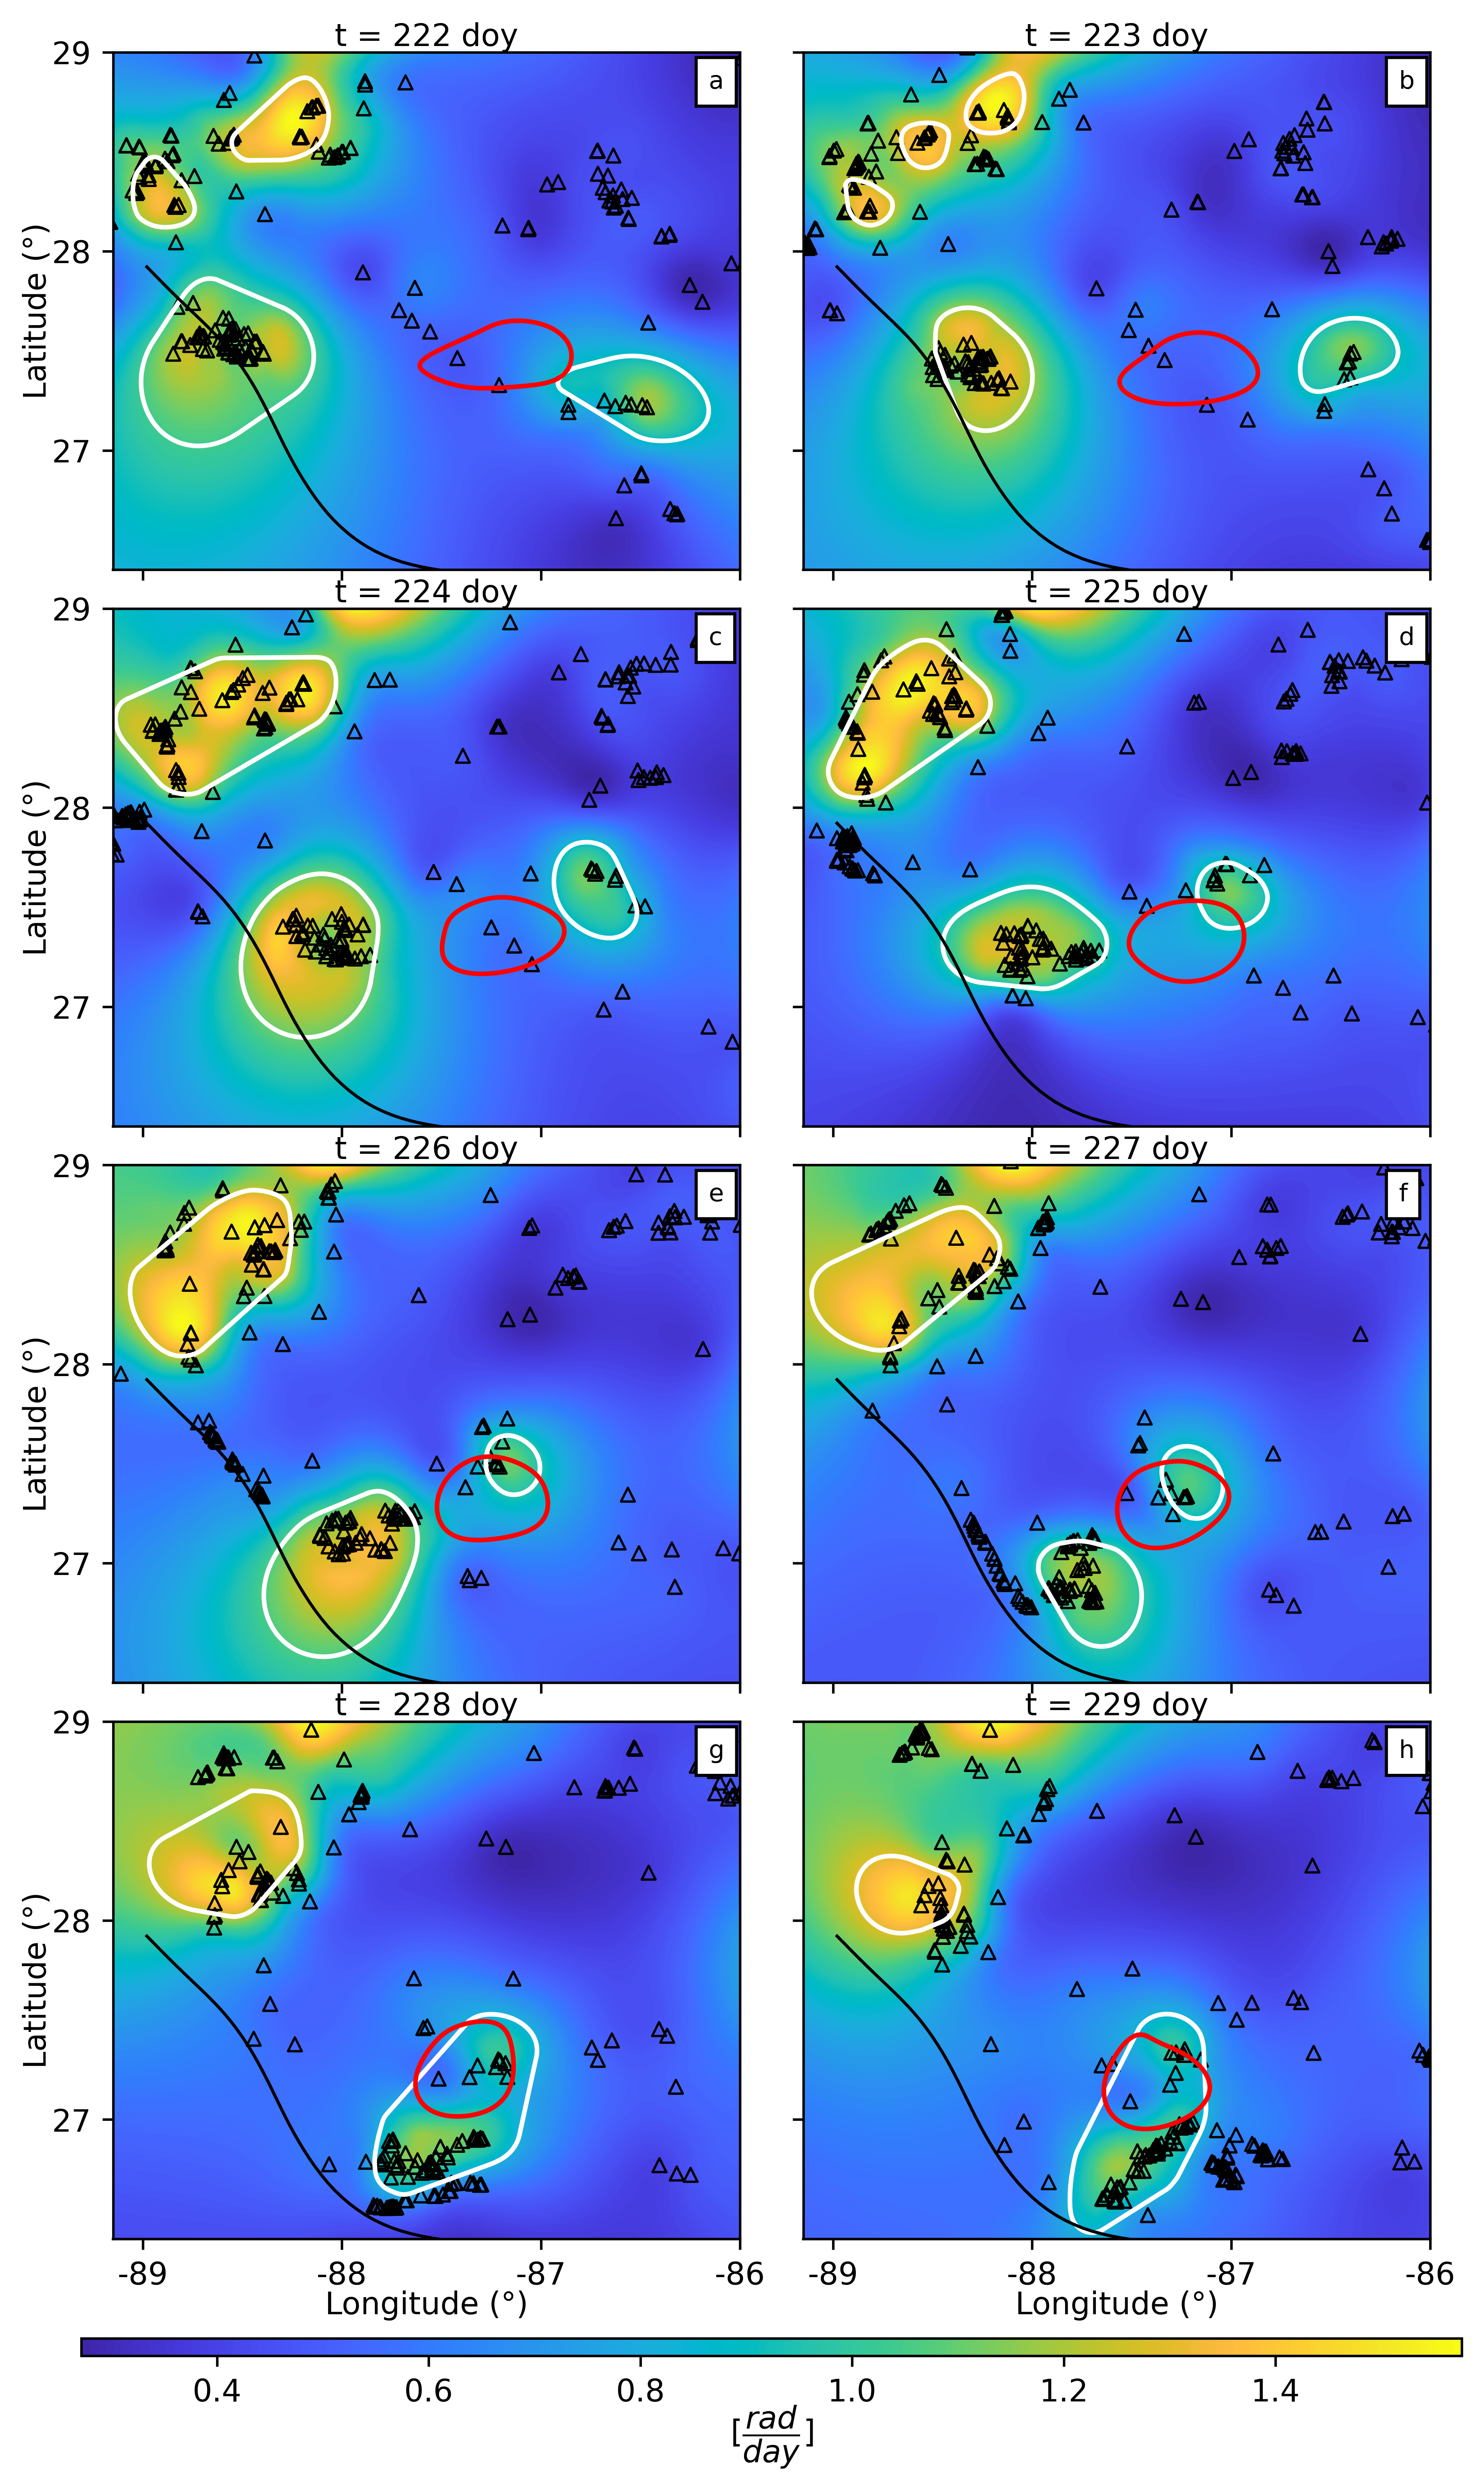

In [9]:
# import plotting library
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datetime import timedelta
from tqdm.notebook import tqdm

fig = plt.figure(figsize = (8, 16), dpi = 600)
ax = []
idx_list = np.arange(0, 96*8, 96)
letters = ["a", "b", "c", "d", "e", "f", "g", "h"]

idx_x = [0, 1, 0, 1, 0, 1, 0, 1]
idx_y = [0, 0, 1, 1, 2, 2, 3, 3]

# Define limits of plot
x_limits = [-89.15, -86]
y_limits = [26.4, 29]

delta_x = x_limits[1]-x_limits[0]
delta_y = y_limits[1]-y_limits[0]

x_min = x_limits[0]
x_max = x_limits[1]
y_min = y_limits[0]
y_max = y_limits[1]

# set initial and final date
date_initial = datetime(2012, 8, 10, 0, 0, 0)
date_final = datetime(2012, 8, 17, 0, 0, 0)

counter = 0

TRA_max = 1.6 # only used for colorbar
TRA_min = 0.4 # only used for colorbar

filesave = r'./figures/fig5.jpeg'

# iterate plots
for idx in tqdm(idx_list):
    
    date = date_initial + timedelta(hours = int(idx/4))
    
    long, lat = [], []
    long_final, lat_final = [], []
    
    # time
    time = d[0][:idx+1]
    
    for d in drifters:
        
        #longitudinal position of drifter d
        longitude = d[1][:idx+1]
        
        # latitudinal position of drifter d
        latitude = d[2][:idx+1]
        
        # Append longitude/latitude
        long.append(longitude)
        lat.append(latitude)
        
        # store final position
        long_final.append(longitude[idx])
        lat_final.append(latitude[idx])
    
    # Date year
    yearday = (date - datetime(2012, 1, 1, 0, 0, 0)).total_seconds() / (3600 * 24)
    
    ax.append(plt.subplot(4, 2, counter+1))
    
    ax[-1].set_xticks(np.arange(np.around(x_min), np.around(x_max) + 1, 1))
    ax[-1].set_yticks(np.arange(np.around(y_min), np.around(y_max) + 1, 1))
    
    if idx_y[counter] == 3:

        ax[-1].set_xticklabels(np.arange(np.around(x_min), np.around(x_max) + 1, 1, dtype = int), fontsize = 10)

    else:
    
        ax[-1].set_xticklabels([])
        
    if idx_x[counter] == 0:
    
        ax[-1].set_yticklabels(np.arange(np.around(y_min), np.around(y_max) + 1, 1, dtype = int), fontsize = 10)
        
    else:
        
        ax[-1].set_yticklabels([])
    
    # scattered linear rbf-interpolation at time[idx] with spatial average filter of size (0.25, 0.25)
    X, Y, TRA_rbf = interpolation(long_final, lat_final, TRA.copy(), resolution, x_min, x_max, y_min, y_max, interp_type = "rbf", kernel_size_deg = kernel_size_deg)
    
    # threshold to local maximum
    threshold_loc_max = .5*np.nanmax(TRA_rbf)

    long_vortex, lat_vortex, centroid = __extract_vortex__(X, Y, TRA_rbf, long_final, lat_final, threshold_loc_max, N_drifters)
    
    ax[-1].set_title("t = " + np.str(int(yearday)) + " doy", fontsize = 10, pad = 0)
    cax = ax[-1].contourf(X, Y, TRA_rbf,
                            zorder=-1, levels=200,
                            cmap=parula_map)
    
    ax[-1].set_xlim([x_min, x_max])
    ax[-1].set_ylim([y_min, y_max])
    ax[-1].scatter(long_final, lat_final, s=20, marker="^", linewidth=.75, edgecolor='k', facecolor='None')
    
    ax[-1].text(.95, .93, letters[counter], c = "k", fontsize = 8, bbox = dict(facecolor='w', edgecolor='k'), transform = ax[-1].transAxes)

    # plot vortex boundaries from TRA
    for idx_vertex in range(len(long_vortex)):
        #if x_min < np.min(long_vortex[idx_vertex]) and np.max(long_vortex[idx_vertex]) < x_max and y_min < np.min(lat_vortex[idx_vertex]) and np.max(lat_vortex[idx_vertex]) < y_max:
        ax[-1].plot(long_vortex[idx_vertex], lat_vortex[idx_vertex], linewidth = 1.5, c = "w")
            #ax[-1].scatter(centroid[idx_vertex][0], centroid[idx_vertex][1], marker = "X", facecolor = "b", edgecolor = "w", linewidth = 1)
        
        if idx_x[counter] == 0:
            ax[-1].set_ylabel("Latitude (°)", fontsize = 10, labelpad = -0.1)
        if idx_y[counter] == 3:
            ax[-1].set_xlabel("Longitude (°)", fontsize = 10, labelpad = -0.1)
    
    # Plot LAVD eddy
    ax[-1].plot(LAVD_x[int(idx/96),0,:],LAVD_x[int(idx/96),1,:], c = "red", linewidth = 1.5)
    
    # Plot attracting LCS
    ax[-1].plot(AttractingLCS_x[0,:50], AttractingLCS_y[0,:50], c = "k", linewidth = 1)

    ax[-1].set_aspect('equal')
    
    plt.subplots_adjust(wspace=0, hspace=0.075)
    
    counter += 1

from matplotlib.ticker import FormatStrFormatter

cbar = fig.colorbar(cax, ax = ax, orientation='horizontal', aspect=80, 
                    ticks=np.arange(.4, 1.4+0.2, 0.2), pad=0.037)

cbar.ax.set_xticklabels(np.around(cbar.get_ticks(),1), fontsize = 10)
cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cbar.ax.set_xlabel(r'$ [\dfrac{rad}{day}] $', rotation=0, labelpad=-1, fontsize = 10)

plt.savefig(filesave, dpi = 600, bbox_inches='tight')
plt.show(fig)